In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import dask.array as da
import xarray as xr
import os


from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import derive_potential_density_values_TEST
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
RHO_SW = 1023.6 # kg/m^3, Density of sea water at 1 atm, 25deg C, 35 g/kg psu
RHO_FW = 997.05 # kg/m^3, Density of fresh water at 25deg C (http://butane.chem.uiuc.edu/pshapley/GenChem1/L21/2.html)
So = 35. # g/kg, Reference salinity psu

In [3]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################
grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)
cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")

southern_ocean_mask_W, southern_ocean_mask_S, so_atl_basin_mask_W, so_atl_basin_mask_S, so_indpac_basin_mask_W, so_indpac_basin_mask_S = ecco_masks.get_basin_masks(maskW, maskS, maskC)


In [34]:
data_dir = "./nctiles_monthly/"
time_slice = np.arange(0,288)

oceFWflx = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"oceFWflx",time_slice,rename_indices=True).assign_coords(time=np.arange(0,288))
oceQnet = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"oceQnet",time_slice,rename_indices=True).assign_coords(time=np.arange(0,288))

PDENS_U = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS_U",time_slice,rename_indices=False).isel(k=0).assign_coords(time=np.arange(0,288))
PDENS_V = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS_V",time_slice,rename_indices=False).isel(k=0).assign_coords(time=np.arange(0,288))
PDENS = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,"PDENS",time_slice,rename_indices=False).isel(k=0).assign_coords(time=np.arange(0,288))

surface_alpha = xr.open_dataset("./analysis_datasets/surface_alpha.nc").rename({"oceQnet":"alpha"}).assign_coords(time=np.arange(0,288))
surface_beta = xr.open_dataset("./analysis_datasets/surface_beta.nc").rename({"oceQnet":"beta"}).assign_coords(time=np.arange(0,288))
surface_heat_capacity = xr.open_dataset("./analysis_datasets/surface_heat_capacity.nc").rename({"oceQnet":"cp"}).assign_coords(time=np.arange(0,288))

Loaded oceFWflx over time slice  

Loaded oceQnet over time slice  

Loaded PDENS_U over time slice  

Loaded PDENS_V over time slice  

Loaded PDENS over time slice  



In [35]:
print(oceFWflx.time,"\n")
print(oceQnet.time,"\n")
print(surface_alpha.time,"\n")
print(surface_beta.time,"\n")
print(surface_heat_capacity.time,"\n")
print(PDENS.time,"\n")

<xarray.DataArray 'time' (time: 288)>
array([  0,   1,   2, ..., 285, 286, 287])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286 287
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 2015-12-16 

<xarray.DataArray 'time' (time: 288)>
array([  0,   1,   2, ..., 285, 286, 287])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286 287
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 2015-12-16 

<xarray.DataArray 'time' (time: 288)>
array([  0,   1,   2, ..., 285, 286, 287])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286 287
    tim      (time) datetime64[ns] ... 

<xarray.DataArray 'time' (time: 288)>
array([  0,   1,   2, ..., 285, 286, 287])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286 287
    tim      (time) datetime64[ns] ... 

<xarray.DataArray 'time' (time: 288)>
array([  0,   1,   2, ..., 285, 286,

In [102]:
Flux_Surface = ((-surface_alpha.alpha/surface_heat_capacity.cp)*oceQnet.oceQnet - (RHO_SW*So/RHO_FW)*surface_beta.beta*oceFWflx.oceFWflx).copy(deep=True)
Flux_Surface_Heat = ((-surface_alpha.alpha/surface_heat_capacity.cp)*oceQnet.oceQnet).copy(deep=True)
Flux_Surface_FW = (-(RHO_SW*So/RHO_FW)*surface_beta.beta*oceFWflx.oceFWflx).copy(deep=True)



Flux_Surface_Southern = Flux_Surface.copy(deep=True)
Flux_Surface_Southern.loc[{"tile":2}] = Flux_Surface.isel(tile=2)*np.nan
Flux_Surface_Southern.loc[{"tile":5}] = Flux_Surface.isel(tile=5)*np.nan
Flux_Surface_Southern.loc[{"tile":6}] = Flux_Surface.isel(tile=6)*np.nan
Flux_Surface_Southern.loc[{"tile":7}] = Flux_Surface.isel(tile=7)*np.nan
Flux_Surface_Southern.loc[{"tile":10}] = Flux_Surface.isel(tile=10)*np.nan

Flux_Surface_Southern_Heat = Flux_Surface_Heat.copy(deep=True)
Flux_Surface_Southern_Heat.loc[{"tile":2}] = Flux_Surface_Heat.isel(tile=2)*np.nan
Flux_Surface_Southern_Heat.loc[{"tile":5}] = Flux_Surface_Heat.isel(tile=5)*np.nan
Flux_Surface_Southern_Heat.loc[{"tile":6}] = Flux_Surface_Heat.isel(tile=6)*np.nan
Flux_Surface_Southern_Heat.loc[{"tile":7}] = Flux_Surface_Heat.isel(tile=7)*np.nan
Flux_Surface_Southern_Heat.loc[{"tile":10}] = Flux_Surface_Heat.isel(tile=10)*np.nan

Flux_Surface_Southern_FW = Flux_Surface_FW.copy(deep=True)
Flux_Surface_Southern_FW.loc[{"tile":2}] = Flux_Surface_FW.isel(tile=2)*np.nan
Flux_Surface_Southern_FW.loc[{"tile":5}] = Flux_Surface_FW.isel(tile=5)*np.nan
Flux_Surface_Southern_FW.loc[{"tile":6}] = Flux_Surface_FW.isel(tile=6)*np.nan
Flux_Surface_Southern_FW.loc[{"tile":7}] = Flux_Surface_FW.isel(tile=7)*np.nan
Flux_Surface_Southern_FW.loc[{"tile":10}] = Flux_Surface_FW.isel(tile=10)*np.nan




Flux_Surface_Northern = Flux_Surface.copy(deep=True)
Flux_Surface_Northern.loc[{"tile":0}] = Flux_Surface.isel(tile=0)*np.nan
Flux_Surface_Northern.loc[{"tile":1}] = Flux_Surface.isel(tile=1)*np.nan
Flux_Surface_Northern.loc[{"tile":3}] = Flux_Surface.isel(tile=3)*np.nan
Flux_Surface_Northern.loc[{"tile":4}] = Flux_Surface.isel(tile=4)*np.nan
Flux_Surface_Northern.loc[{"tile":8}] = Flux_Surface.isel(tile=8)*np.nan
Flux_Surface_Northern.loc[{"tile":9}] = Flux_Surface.isel(tile=9)*np.nan
Flux_Surface_Northern.loc[{"tile":11}] = Flux_Surface.isel(tile=11)*np.nan
Flux_Surface_Northern.loc[{"tile":12}] = Flux_Surface.isel(tile=12)*np.nan

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

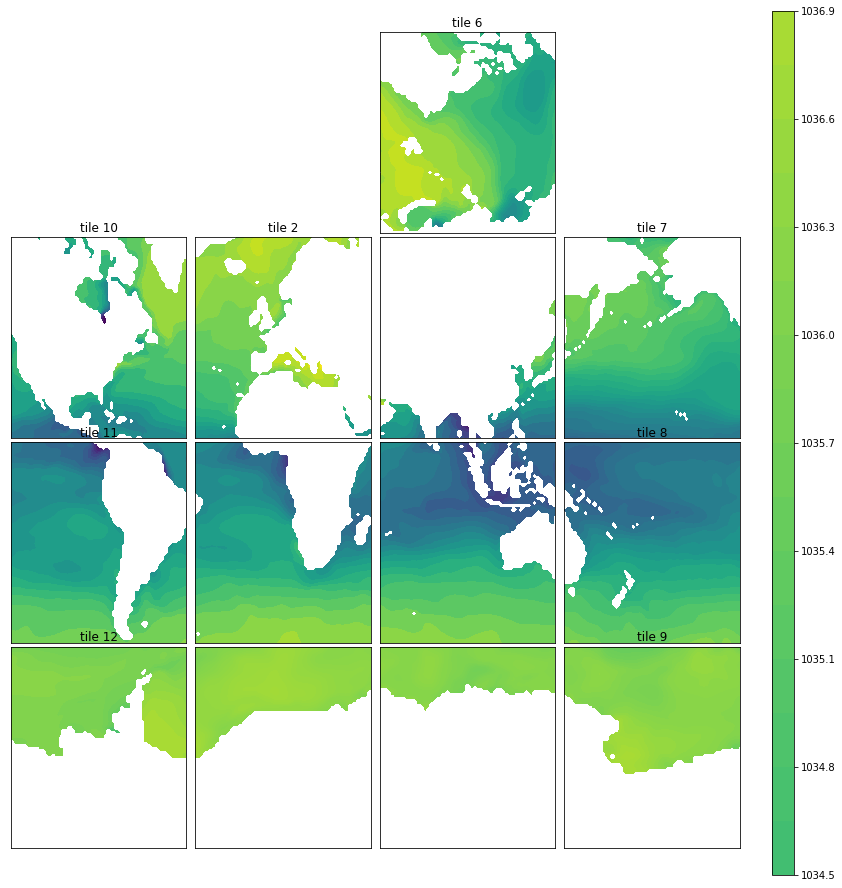

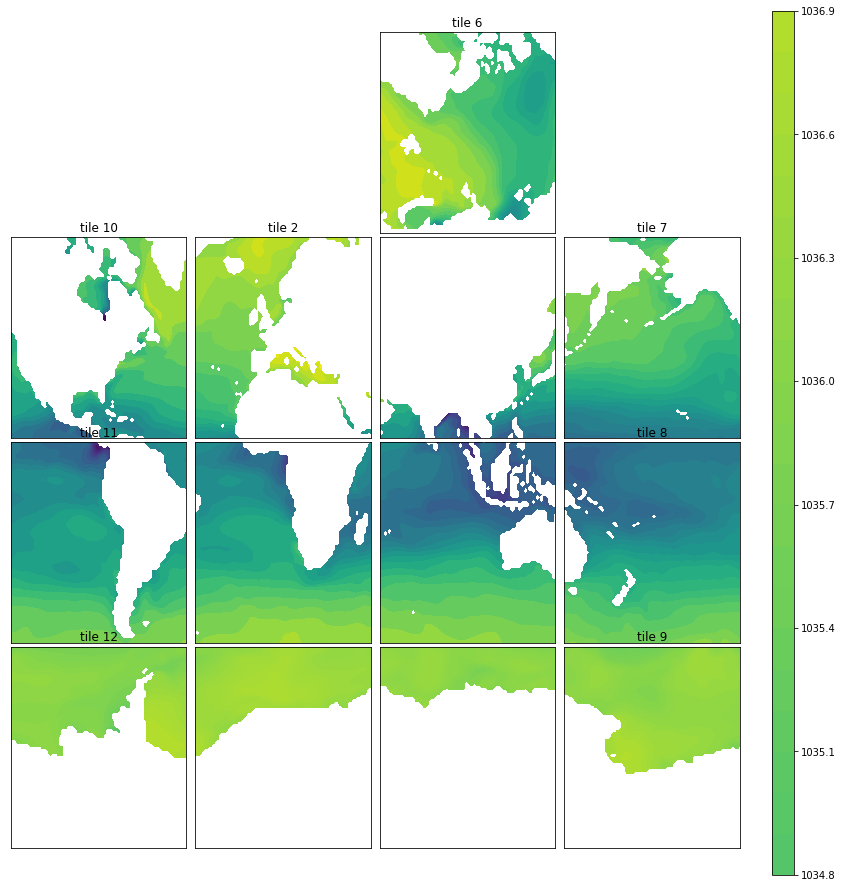

In [100]:
plotting_functions.world_plot(PDENS_U.PDENS.isel(time=0))
plotting_functions.world_plot(PDENS_V.PDENS.isel(time=0))

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

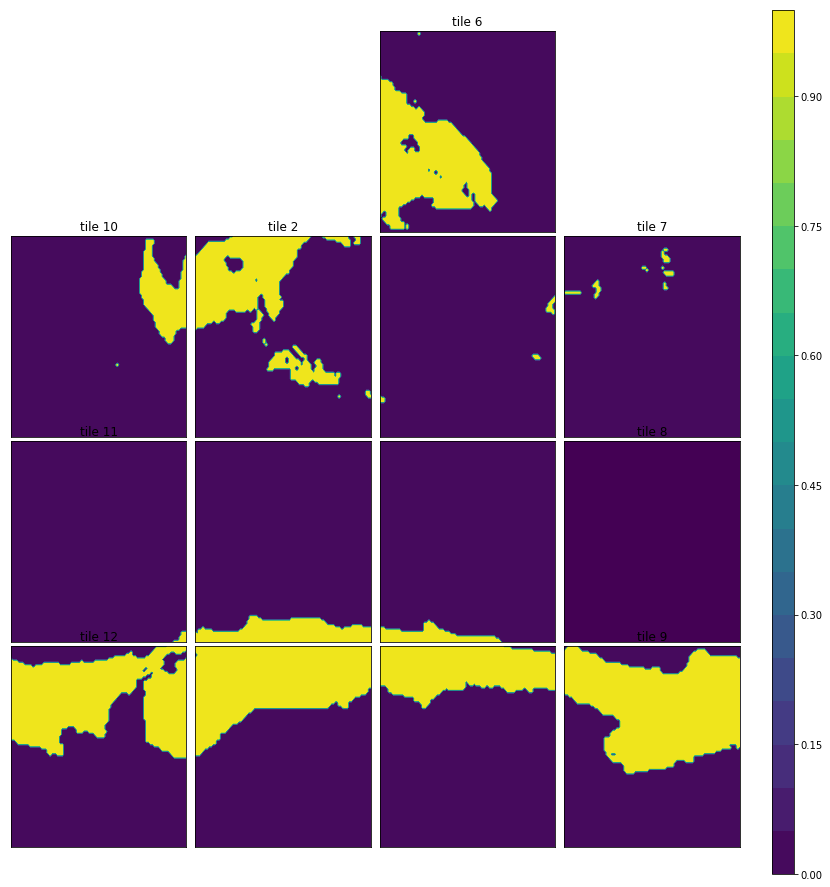

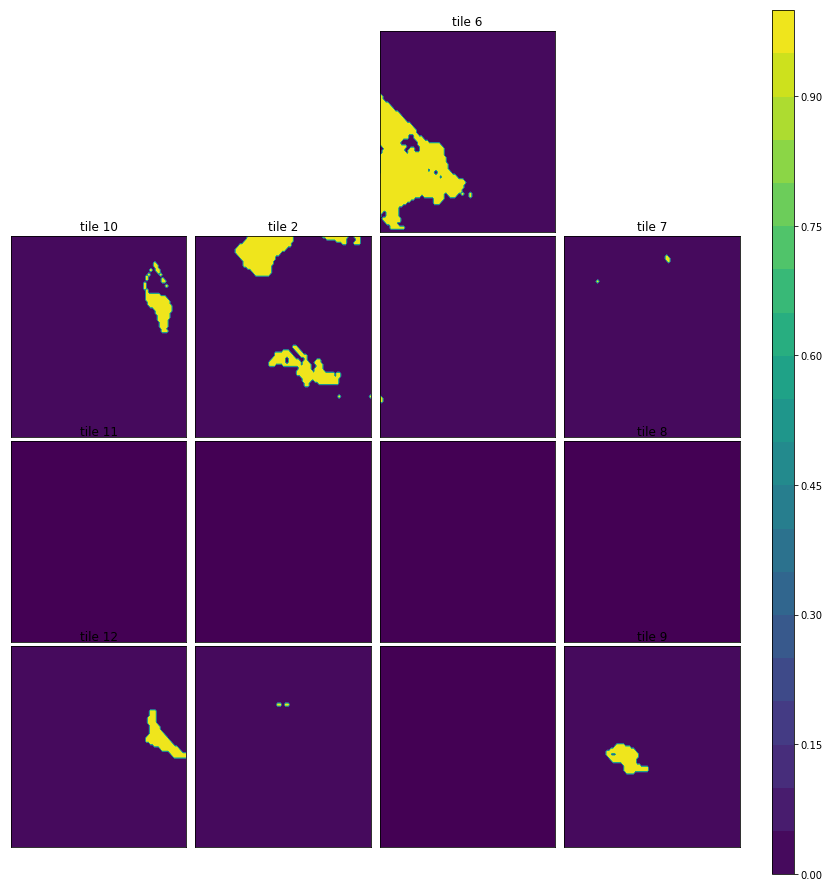

In [145]:
plotting_functions.world_plot(PDENS_V.PDENS.isel(time=2) > 1036.0)
plotting_functions.world_plot(PDENS_V.PDENS.isel(time=2) > 1036.82)

In [136]:
def calculate_Fgen(Flux_Surface_Southern,grid,PDENS):
    ######################################################################################################################
    ########################################## Integrate Horizontally ####################################################
    ######################################################################################################################

    time_slice = np.arange(0,288)

    pot_dens_coord = np.arange(1028.0,1033.9,0.2)
    pot_dens_coord = np.concatenate((np.asarray([1000.]),pot_dens_coord, np.arange(1034.0,1036,0.1), np.arange(1036.0,1038,0.02)))


    # set dimensions based on input dataset with modified vertical level spacing..
    F_int_dims = (len(time_slice),
                  len(pot_dens_coord)
                 )

    empty_F_int_data = np.zeros(F_int_dims)
    # trying to make this as general as possible, but need to keep an eye on this..
    new_coords = [time_slice, 
                  pot_dens_coord, 
                  ]
    new_dims = ["time", 
                "pot_rho", 
                ]

    F_int_dataarray = xr.DataArray(data=empty_F_int_data,coords=new_coords,dims=new_dims)
    F_int_dataarray.load()

    # calculate integral of surface flux over time period..
    for density in pot_dens_coord:
        F_int_dataarray.loc[{"pot_rho":density}]=(Flux_Surface_Southern*grid.rA.where(PDENS.PDENS > density)).sum(dim=["i","j","tile"])
        print("Done "+str(density)+" surface")




    ######################################################################################################################
    #################################### DERIVE LATITUDINAL DENSITY MINIMA ###############################################
    ######################################################################################################################
    time_slice = np.arange(0,288)

    lat_vals = np.arange(-88,0)

    # set dimensions based on input dataset with modified vertical level spacing..
    dens_minima_dims = (len(time_slice),
                        len(lat_vals))

    empty_dens_minima_data = np.zeros(dens_minima_dims)
    # trying to make this as general as possible, but need to keep an eye on this..
    new_coords = [time_slice, 
                  lat_vals]
    new_dims = ["time",  
                "lat"]

    dens_minima_dataarray = xr.DataArray(data=empty_dens_minima_data,coords=new_coords,dims=new_dims)
    dens_minima_dataarray_x = dens_minima_dataarray.copy(deep=True)
    dens_minima_dataarray_y = dens_minima_dataarray.copy(deep=True)

    print('starting lat-band filtering')
    for lat in lat_vals:
        print(str(lat)+' ',end='')
        # Compute mask for particular latitude band
        # since transport values are in native grid coordaintes you need to combine the sum of the transports in 
        # the x and y direction and vis versa for tiles 0-5 and 7-12, respectively
        lat_maskX, lat_maskY = ecco.vector_calc.get_latitude_masks(lat, cds['YC'], grid_xmitgcm)
        # Sum horizontally
        lat_min_x = (PDENS.PDENS.rename({"i":"i_g"}) * np.absolute(lat_maskX)).where(lat_maskX != 0,other=np.nan).min(dim=['i_g','j','tile'],skipna=True)
        lat_min_y = (PDENS.PDENS.rename({"j":"j_g"}) * np.absolute(lat_maskY)).where(lat_maskY != 0,other=np.nan).min(dim=['i','j_g','tile'],skipna=True)
        dens_minima_dataarray_x.loc[{'lat':lat}] = lat_min_x
        dens_minima_dataarray_y.loc[{'lat':lat}] = lat_min_y
        dens_minima_dataarray.loc[{'lat':lat}] = np.amin(np.asarray([lat_min_x.values,lat_min_y.values]),axis=0)


    print("\n")



    ######################################################################################################################
    ################################### MMM APPLY THAT FINITE DIFFERENCE BEBE ############################################
    ######################################################################################################################

    F_int_dataarray_shifted_down = F_int_dataarray*0+np.concatenate((F_int_dataarray[:,0:1].values*np.nan,F_int_dataarray[:,:-1].values),axis=1)
    F_int_dataarray_shifted_up = F_int_dataarray*0+np.concatenate((F_int_dataarray[:,1:].values,F_int_dataarray[:,0:1].values*np.nan),axis=1)

    pot_rho_shifted_down = F_int_dataarray.pot_rho*0+np.concatenate((F_int_dataarray.pot_rho[0:1].values*np.nan,F_int_dataarray.pot_rho[:-1].values))
    pot_rho_shifted_up = F_int_dataarray.pot_rho*0+np.concatenate((F_int_dataarray.pot_rho[1:].values,F_int_dataarray.pot_rho[0:1].values*np.nan))

    finite_diff_F_int_dataarray = (F_int_dataarray_shifted_down - F_int_dataarray_shifted_up)/(pot_rho_shifted_down - pot_rho_shifted_up)

    
    return finite_diff_F_int_dataarray


finite_diff_F_int_dataarray = calculate_Fgen(Flux_Surface_Southern,grid,PDENS)
finite_diff_F_Heat_int_dataarray = calculate_Fgen(Flux_Surface_Southern_Heat,grid,PDENS)
finite_diff_F_FW_int_dataarray = calculate_Fgen(Flux_Surface_Southern_FW,grid,PDENS)

Done 1000.0 surface
Done 1028.0 surface
Done 1028.2 surface
Done 1028.4 surface
Done 1028.6000000000001 surface
Done 1028.8000000000002 surface
Done 1029.0000000000002 surface
Done 1029.2000000000003 surface
Done 1029.4000000000003 surface
Done 1029.6000000000004 surface
Done 1029.8000000000004 surface
Done 1030.0000000000005 surface
Done 1030.2000000000005 surface
Done 1030.4000000000005 surface
Done 1030.6000000000006 surface
Done 1030.8000000000006 surface
Done 1031.0000000000007 surface
Done 1031.2000000000007 surface
Done 1031.4000000000008 surface
Done 1031.6000000000008 surface
Done 1031.8000000000009 surface
Done 1032.000000000001 surface
Done 1032.200000000001 surface
Done 1032.400000000001 surface
Done 1032.600000000001 surface
Done 1032.800000000001 surface
Done 1033.0000000000011 surface
Done 1033.2000000000012 surface
Done 1033.4000000000012 surface
Done 1033.6000000000013 surface
Done 1033.8000000000013 surface
Done 1034.0 surface
Done 1034.1 surface
Done 1034.19999999999

Done 1037.059999999999 surface
Done 1037.079999999999 surface
Done 1037.099999999999 surface
Done 1037.119999999999 surface
Done 1037.139999999999 surface
Done 1037.159999999999 surface
Done 1037.179999999999 surface
Done 1037.199999999999 surface
Done 1037.219999999999 surface
Done 1037.2399999999989 surface
Done 1037.2599999999989 surface
Done 1037.2799999999988 surface
Done 1037.2999999999988 surface
Done 1037.3199999999988 surface
Done 1037.3399999999988 surface
Done 1037.3599999999988 surface
Done 1037.3799999999987 surface
Done 1037.3999999999987 surface
Done 1037.4199999999987 surface
Done 1037.4399999999987 surface
Done 1037.4599999999987 surface
Done 1037.4799999999987 surface
Done 1037.4999999999986 surface
Done 1037.5199999999986 surface
Done 1037.5399999999986 surface
Done 1037.5599999999986 surface
Done 1037.5799999999986 surface
Done 1037.5999999999985 surface
Done 1037.6199999999985 surface
Done 1037.6399999999985 surface
Done 1037.6599999999985 surface
Done 1037.6799999

In [137]:
import labellines

In [138]:
def plot_surface_transformations_t_vs_p(finite_diff_F_int_dataarray,dens_minima_dataarray,dens_minima_lats,tmin,tmax):
    time_slice=slice(tmin,tmax)
    plt.figure(figsize=(40,20))
    indicies = []
    levels = np.arange(-3.0e8,3.1e8,2e7)/1e6
    for i in range(0,tmax-tmin):
        indicies.append(str(oceFWflx.tim.isel(time=time_slice).values[i])[:10])

    for lat in dens_minima_lats:
        plt.plot(np.arange(tmin,tmax),
                dens_minima_dataarray.isel(time=time_slice,lat=lat),
                c="k",
                label=str(lat))

    labellines.labelLines(plt.gca().get_lines())

    plt.contourf(np.arange(tmin,tmax),
               #SALT.tim.isel(time=slice(0,48)),
               finite_diff_F_int_dataarray.isel(time=time_slice,pot_rho=slice(1,151)).pot_rho,
               finite_diff_F_int_dataarray.isel(time=time_slice,pot_rho=slice(1,151)).transpose("pot_rho","time")/(1e6),
                levels=levels,
                cmap="seismic")
    cbar = plt.colorbar()
    cbar.set_label("Surface Transformations (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
    plt.grid()
    plt.xlabel("Time (yyyy-mm)",fontname='Times New Roman',fontsize=16,)
    plt.ylabel("Potential Density",fontname='Times New Roman',fontsize=16,)
    plt.xticks(np.arange(tmin,tmax,4),indicies[::4])
    plt.gca().invert_yaxis()
    plt.title("Surface Transformations Across Isolines from "+indicies[0]+" to "+indicies[-1],fontname='Times New Roman',fontsize=30)
    plt.show()



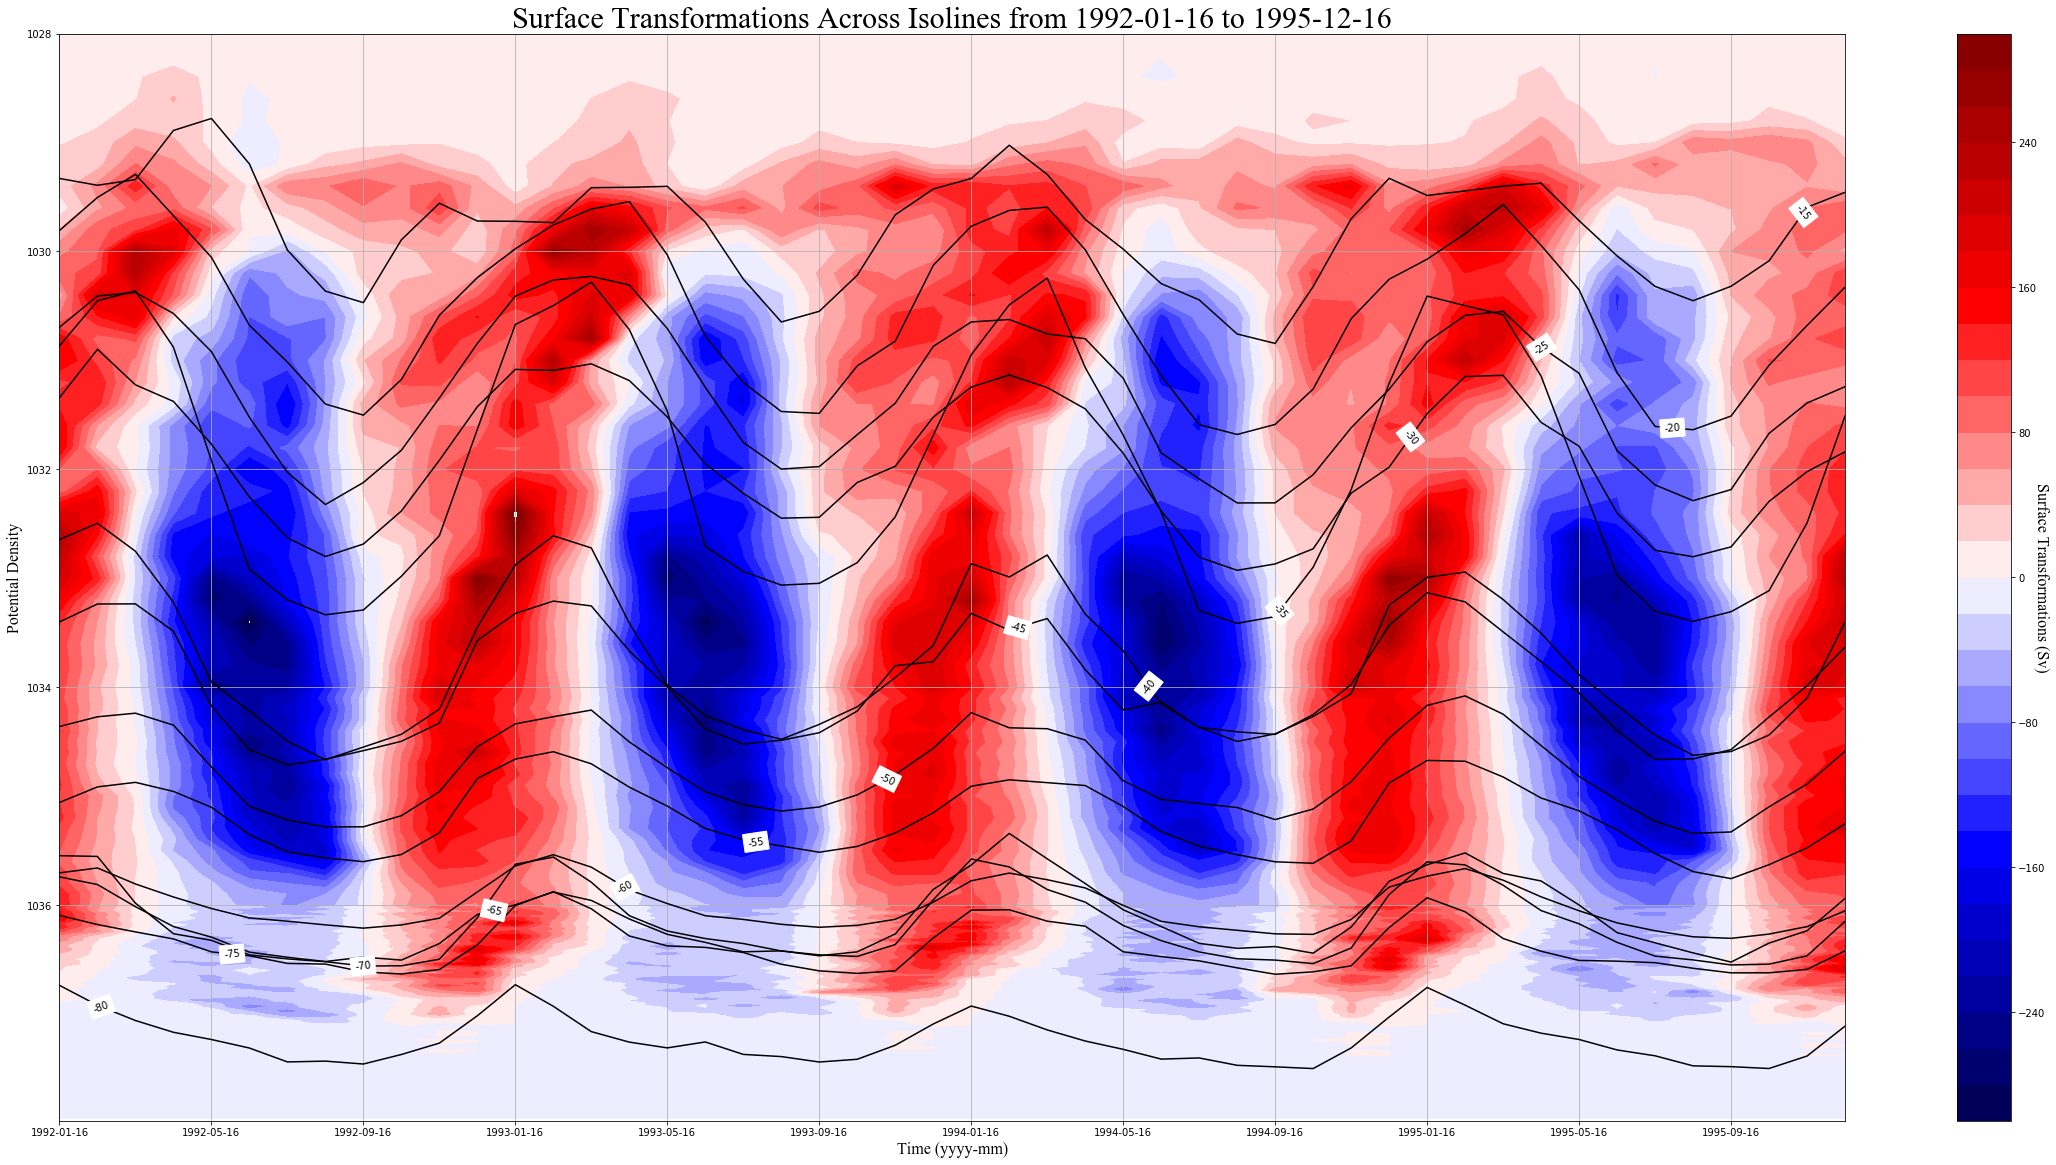

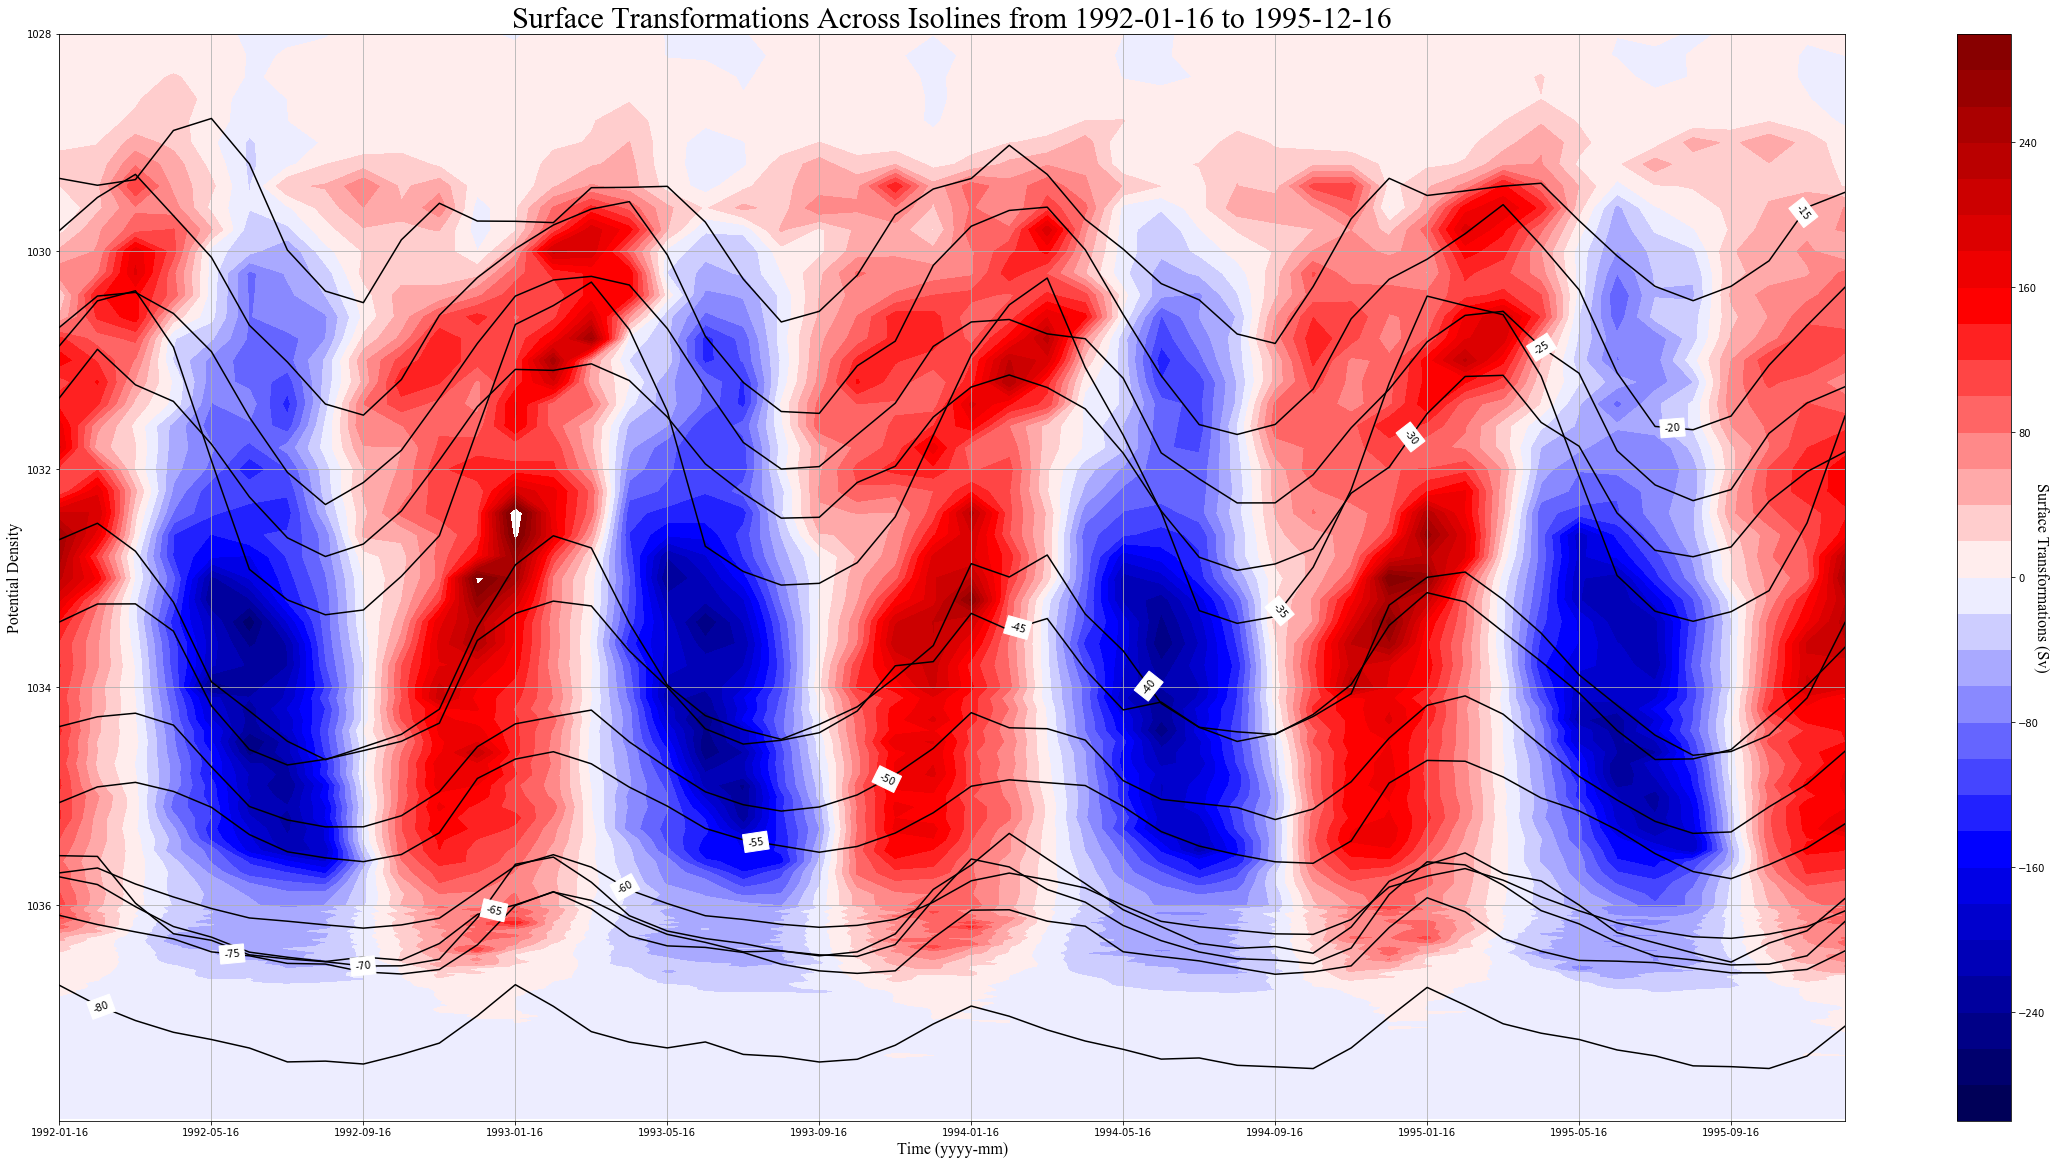

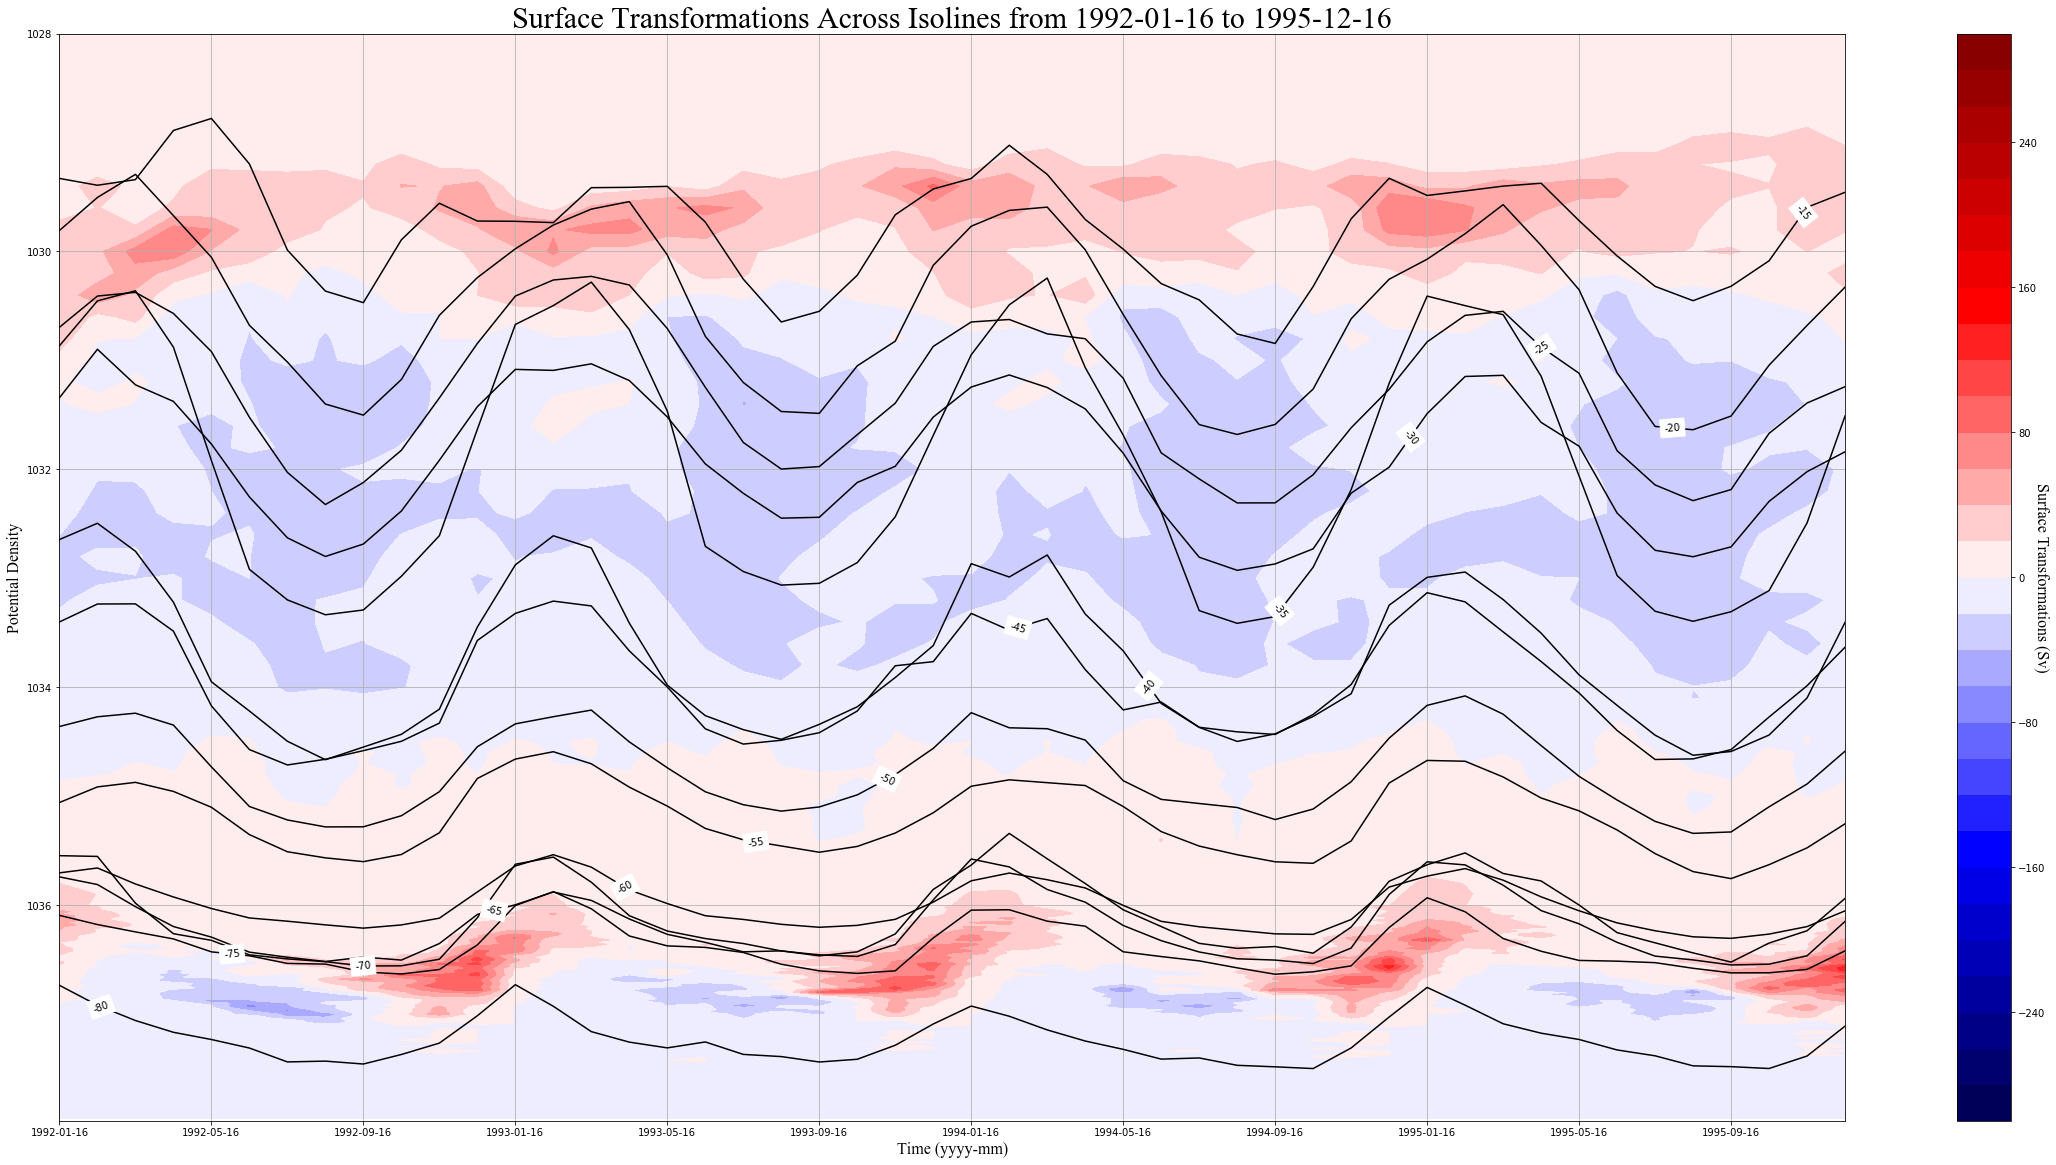

In [139]:
plot_surface_transformations_t_vs_p(finite_diff_F_int_dataarray,dens_minima_dataarray,np.arange(-80,-10,5),0,48)
plot_surface_transformations_t_vs_p(finite_diff_F_Heat_int_dataarray,dens_minima_dataarray,np.arange(-80,-10,5),0,48)
plot_surface_transformations_t_vs_p(finite_diff_F_FW_int_dataarray,dens_minima_dataarray,np.arange(-80,-10,5),0,48)



In [140]:
######################################################################################################################
############################################ Create F_gen Array ######################################################
######################################################################################################################
lat_vals = np.arange(-88,0)
time_slice = np.arange(0,288)

pot_dens_coord = np.arange(1028.0,1033.9,0.2)
pot_dens_coord = np.concatenate((np.asarray([1000.]),pot_dens_coord, np.arange(1034.0,1036,0.1), np.arange(1036.0,1038,0.02)))



# set dimensions based on input dataset with modified vertical level spacing..
F_int_dims = (len(time_slice),
              len(pot_dens_coord),
              len(lat_vals)
             )

empty_F_int_data = np.zeros(F_int_dims)
# trying to make this as general as possible, but need to keep an eye on this..
new_coords = [time_slice, 
              pot_dens_coord,
              lat_vals
              ]
new_dims = ["time", 
            "pot_rho", 
            "lat"
            ]

F_gen_array = xr.DataArray(data=empty_F_int_data,coords=new_coords,dims=new_dims)
F_gen_array.load()
F_gen_Heat_array = F_gen_array.copy(deep=True)
F_gen_FW_array = F_gen_array.copy(deep=True)



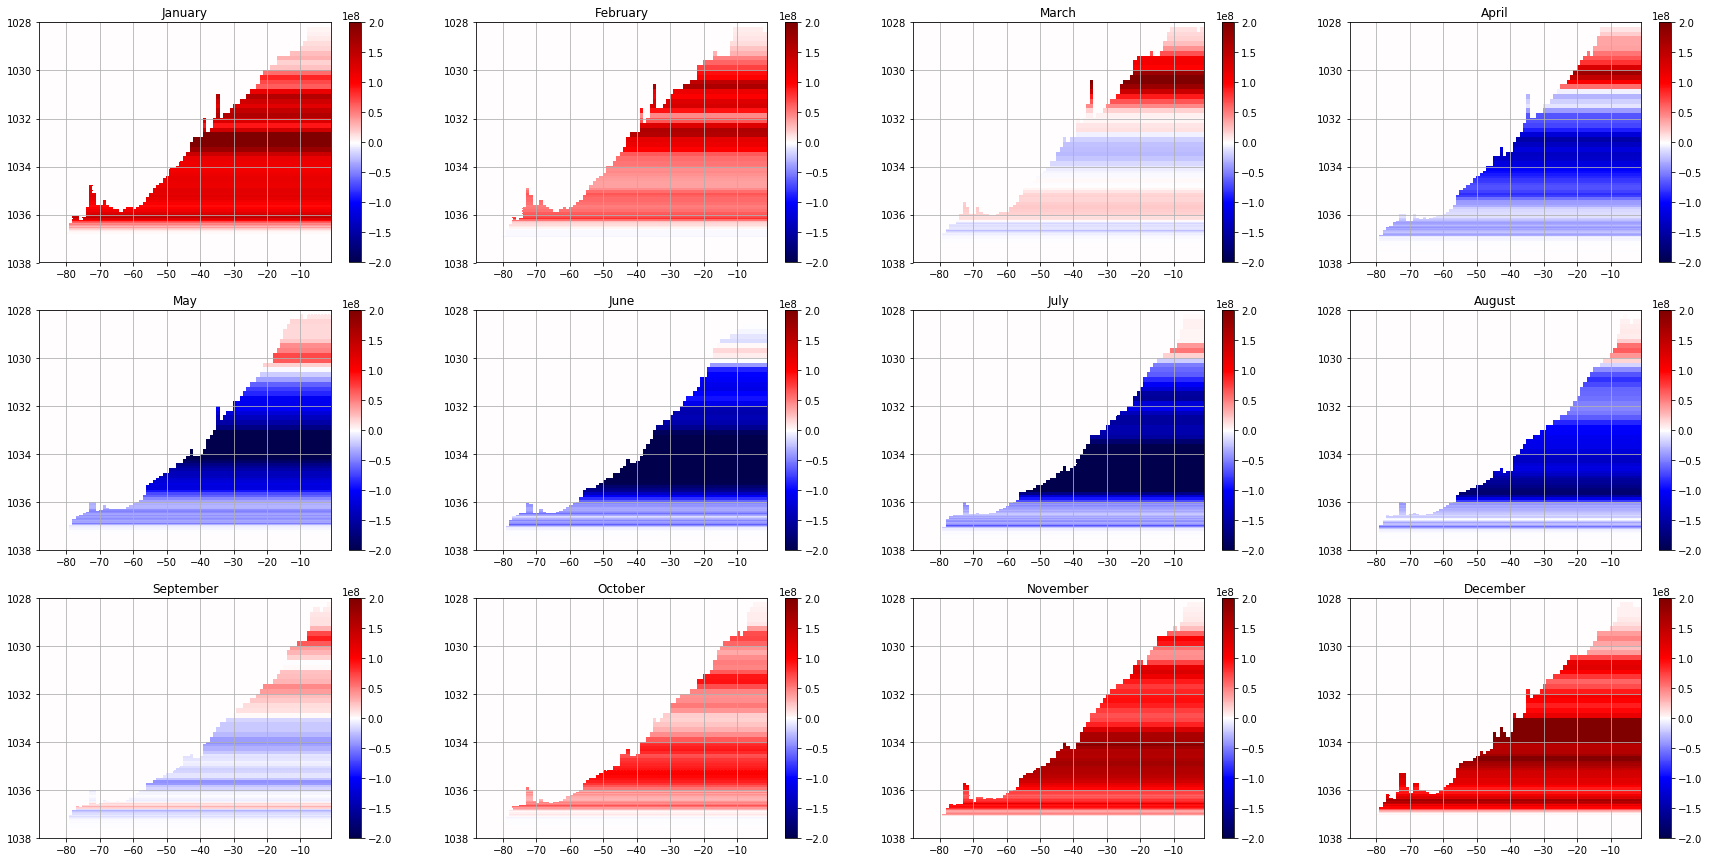

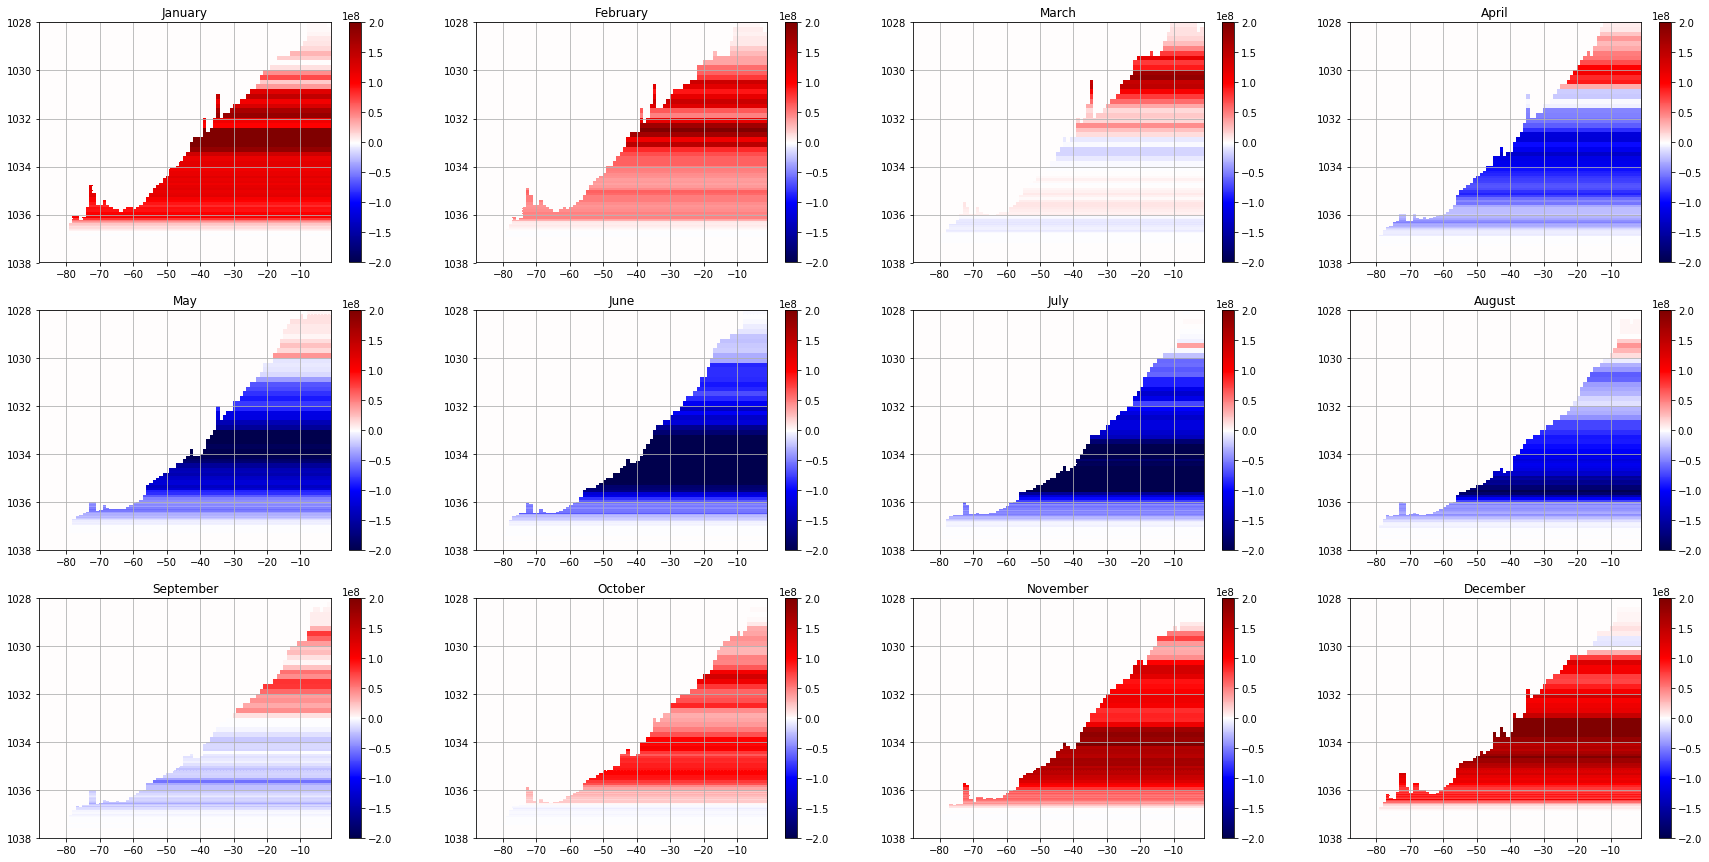

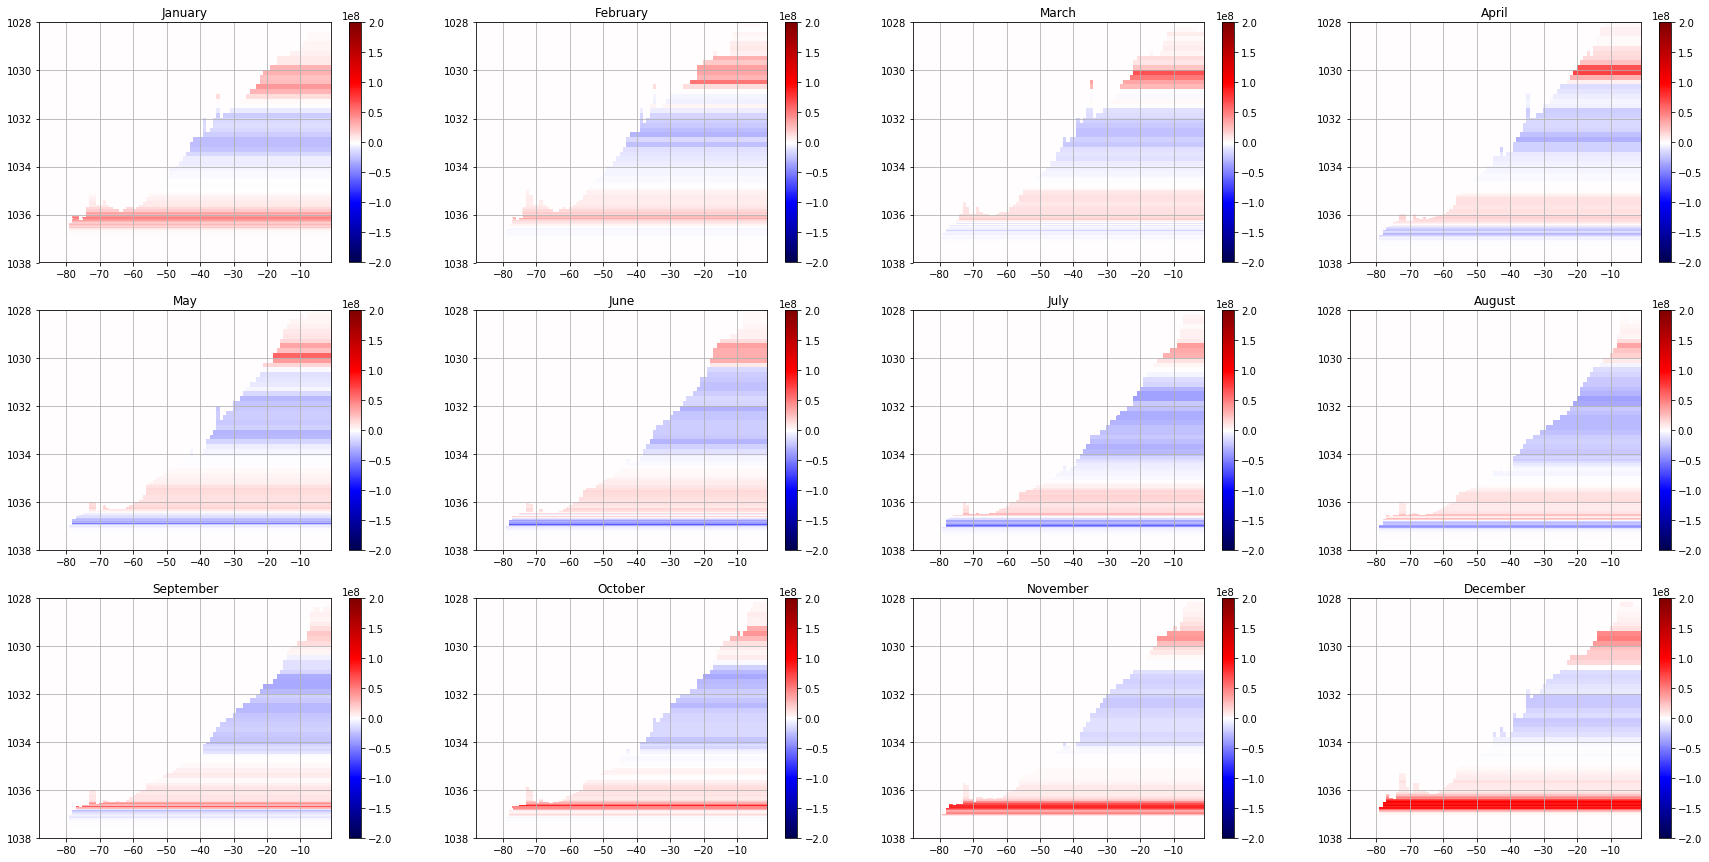

In [141]:
for lat in lat_vals:
    F_gen_array.loc[{"lat":lat}] = finite_diff_F_int_dataarray_copy.where(finite_diff_F_int_dataarray_copy.pot_rho > dens_minima_dataarray.isel(lat=lat),other=0)
    F_gen_Heat_array.loc[{"lat":lat}] = finite_diff_F_Heat_int_dataarray.where(finite_diff_F_Heat_int_dataarray.pot_rho > dens_minima_dataarray.isel(lat=lat),other=0)
    F_gen_FW_array.loc[{"lat":lat}] = finite_diff_F_FW_int_dataarray.where(finite_diff_F_FW_int_dataarray.pot_rho > dens_minima_dataarray.isel(lat=lat),other=0)


def plot_first_year(F_gen_array):
    
    fig = plt.figure(figsize=(30,15))
    gs = gridspec.GridSpec(nrows=3,ncols=4)
    pmax = 2e8
    pmin = -2e8
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[0,2])
    ax3 = fig.add_subplot(gs[0,3])
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    ax7 = fig.add_subplot(gs[1,3])
    ax8 = fig.add_subplot(gs[2,0])
    ax9 = fig.add_subplot(gs[2,1])
    ax10 = fig.add_subplot(gs[2,2])
    ax11 = fig.add_subplot(gs[2,3])


    im0 = ax0.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=0)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im1 = ax1.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=1)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im2 = ax2.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=2)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im3 = ax3.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=3)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im4 = ax4.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=4)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im5 = ax5.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=5)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im6 = ax6.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=6)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im7 = ax7.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=7)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im8 = ax8.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=8)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im9 = ax9.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=9)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im10 = ax10.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=10)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)
    im11 = ax11.pcolor(F_gen_array.lat,F_gen_array.pot_rho[1:],F_gen_array.isel(time=11)[1:,:],cmap="seismic",vmin=pmin,vmax=pmax)

    ax0.invert_yaxis()
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    ax5.invert_yaxis()
    ax6.invert_yaxis()
    ax7.invert_yaxis()
    ax8.invert_yaxis()
    ax9.invert_yaxis()
    ax10.invert_yaxis()
    ax11.invert_yaxis()

    ax0.grid()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()
    ax7.grid()
    ax8.grid()
    ax9.grid()
    ax10.grid()
    ax11.grid()

    ax0.set_title("January")
    ax1.set_title("February")
    ax2.set_title("March")
    ax3.set_title("April")
    ax4.set_title("May")
    ax5.set_title("June")
    ax6.set_title("July")
    ax7.set_title("August")
    ax8.set_title("September")
    ax9.set_title("October")
    ax10.set_title("November")
    ax11.set_title("December")

    fig.colorbar(im0,ax=ax0)
    fig.colorbar(im1,ax=ax1)
    fig.colorbar(im2,ax=ax2)
    fig.colorbar(im3,ax=ax3)
    fig.colorbar(im4,ax=ax4)
    fig.colorbar(im5,ax=ax5)
    fig.colorbar(im6,ax=ax6)
    fig.colorbar(im7,ax=ax7)
    fig.colorbar(im8,ax=ax8)
    fig.colorbar(im9,ax=ax9)
    fig.colorbar(im10,ax=ax10)
    fig.colorbar(im11,ax=ax11)

    plt.show()

plot_first_year(F_gen_array)
plot_first_year(F_gen_Heat_array)
plot_first_year(F_gen_FW_array)

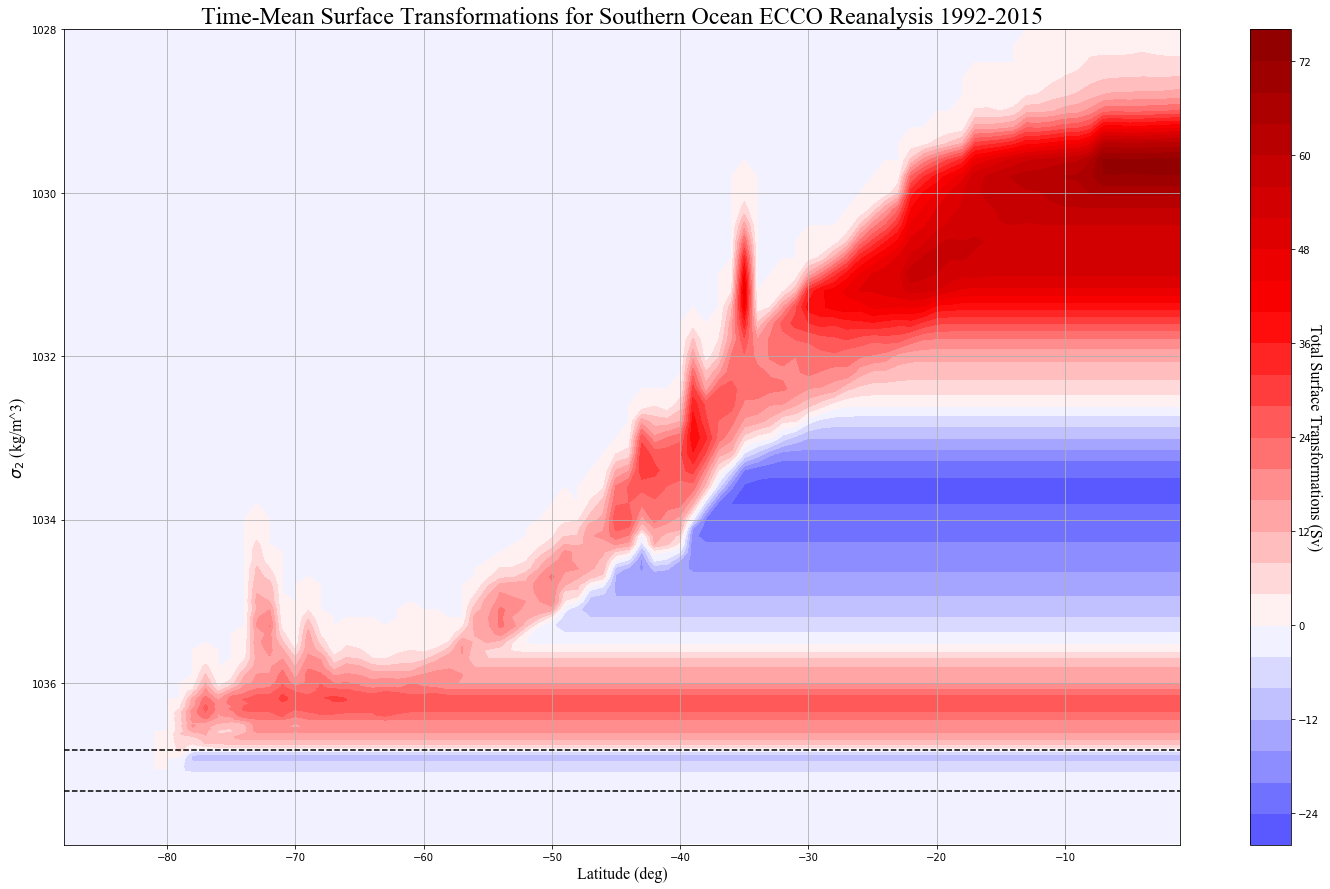

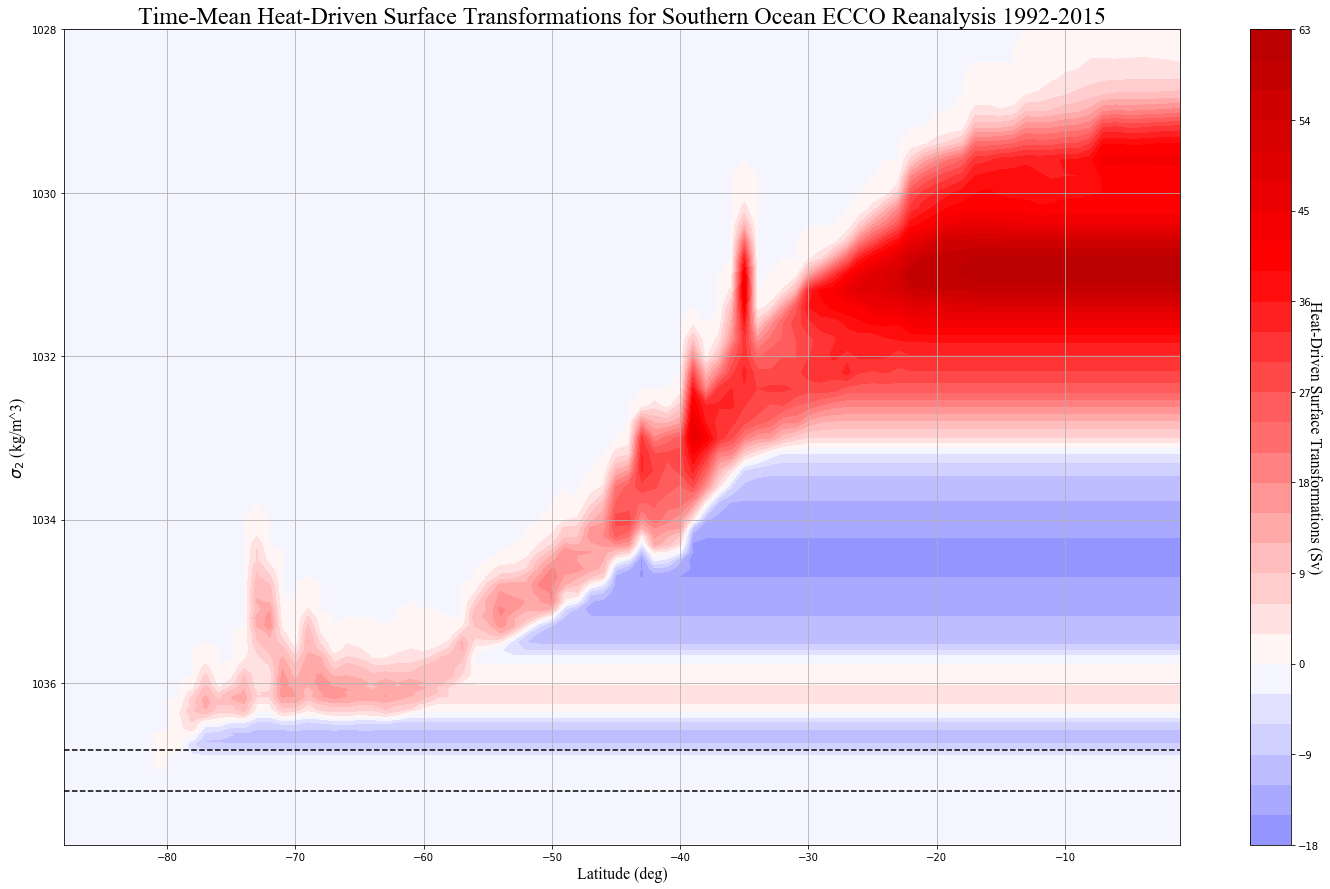

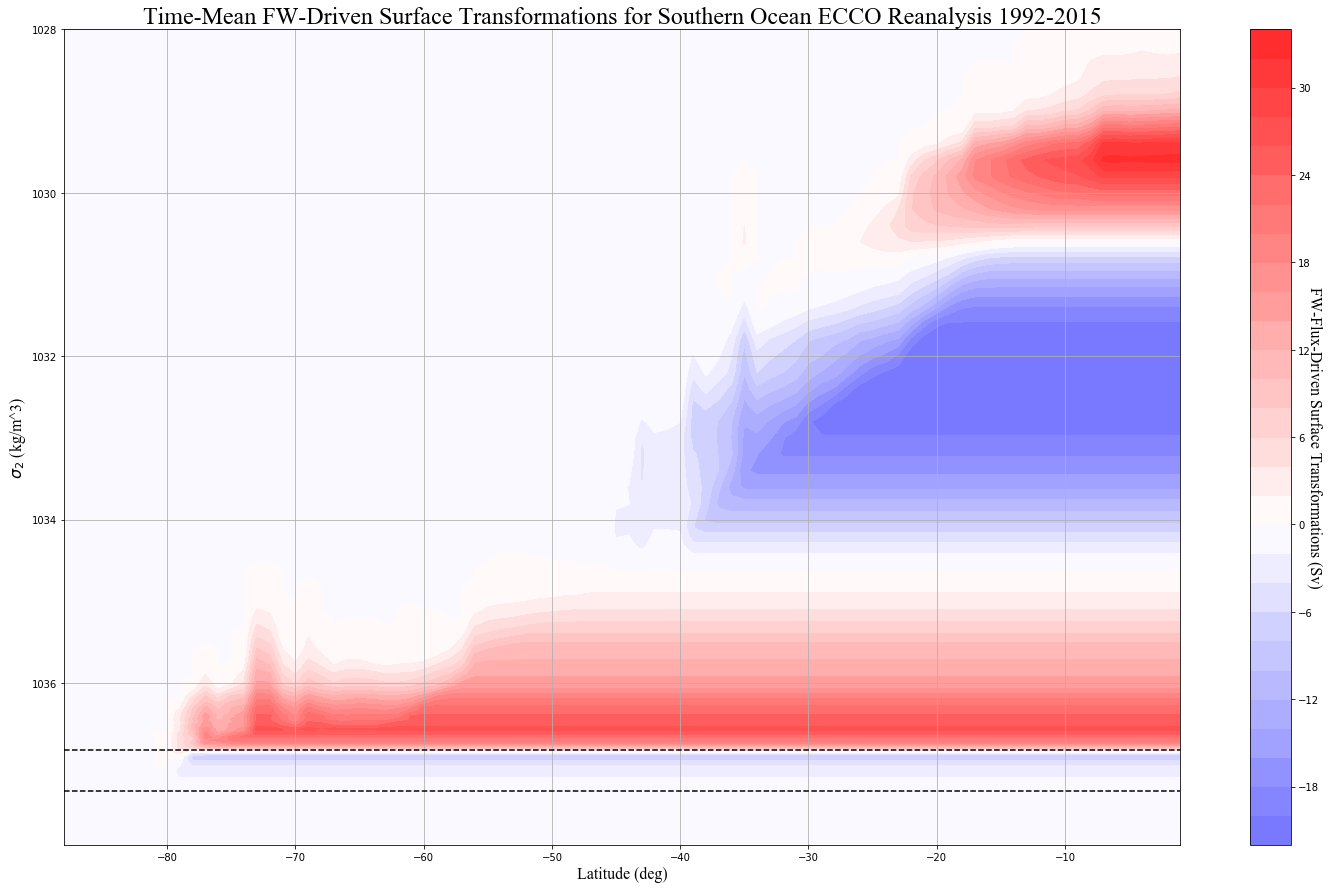

In [156]:
F_gen_array_t_mean = F_gen_array.mean(dim="time")
F_gen_Heat_array_t_mean = F_gen_Heat_array.mean(dim="time")
F_gen_FW_array_t_mean = F_gen_FW_array.mean(dim="time")


plt.figure(figsize=(25,15))
pmax = 80
pmin = -80
plt.contourf(F_gen_array_t_mean.lat,F_gen_array_t_mean.pot_rho[1:],F_gen_array_t_mean[1:,:]/(1e6),30,cmap='seismic',vmin=pmin,vmax=pmax)
plt.gca().invert_yaxis()
plt.title("Time-Mean Surface Transformations for Southern Ocean ECCO Reanalysis 1992-2015",fontname='times new roman',fontsize=24)
cbar = plt.colorbar()
cbar.set_label("Total Surface Transformations (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.axhline(y=1036.82, color='k', linestyle='--',label="1036.82 $\sigma_{2}$ line")
plt.axhline(y=1037.32, color='k', linestyle='--',label="1037.32 $\sigma_{2}$ line")
plt.grid()
plt.show()
plt.close()

plt.figure(figsize=(25,15))
pmax = 80
pmin = -80
plt.contourf(F_gen_array_t_mean.lat,F_gen_array_t_mean.pot_rho[1:],F_gen_Heat_array_t_mean[1:,:]/(1e6),30,cmap='seismic',vmin=pmin,vmax=pmax)
plt.gca().invert_yaxis()
plt.title("Time-Mean Heat-Driven Surface Transformations for Southern Ocean ECCO Reanalysis 1992-2015",fontname='times new roman',fontsize=24)
cbar = plt.colorbar()
cbar.set_label("Heat-Driven Surface Transformations (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.axhline(y=1036.82, color='k', linestyle='--',label="1036.82 $\sigma_{2}$ line")
plt.axhline(y=1037.32, color='k', linestyle='--',label="1037.32 $\sigma_{2}$ line")
plt.grid()
plt.show()
plt.close()

plt.figure(figsize=(25,15))
pmax = 80
pmin = -80
plt.contourf(F_gen_array_t_mean.lat,F_gen_array_t_mean.pot_rho[1:],F_gen_FW_array_t_mean[1:,:]/(1e6),30,cmap='seismic',vmin=pmin,vmax=pmax)
plt.gca().invert_yaxis()
plt.title("Time-Mean FW-Driven Surface Transformations for Southern Ocean ECCO Reanalysis 1992-2015",fontname='times new roman',fontsize=24)
cbar = plt.colorbar()
cbar.set_label("FW-Flux-Driven Surface Transformations (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.axhline(y=1036.82, color='k', linestyle='--',label="1036.82 $\sigma_{2}$ line")
plt.axhline(y=1037.32, color='k', linestyle='--',label="1037.32 $\sigma_{2}$ line")
plt.grid()
plt.show()
plt.close()


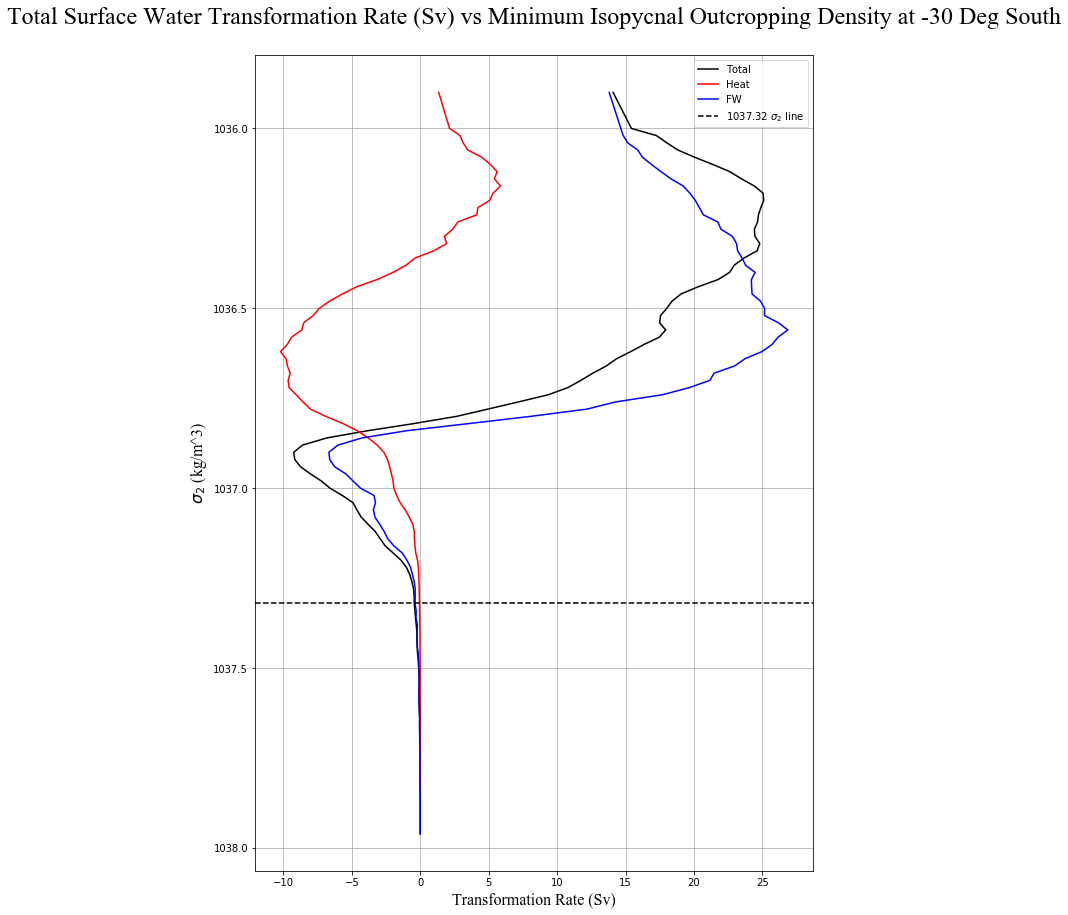

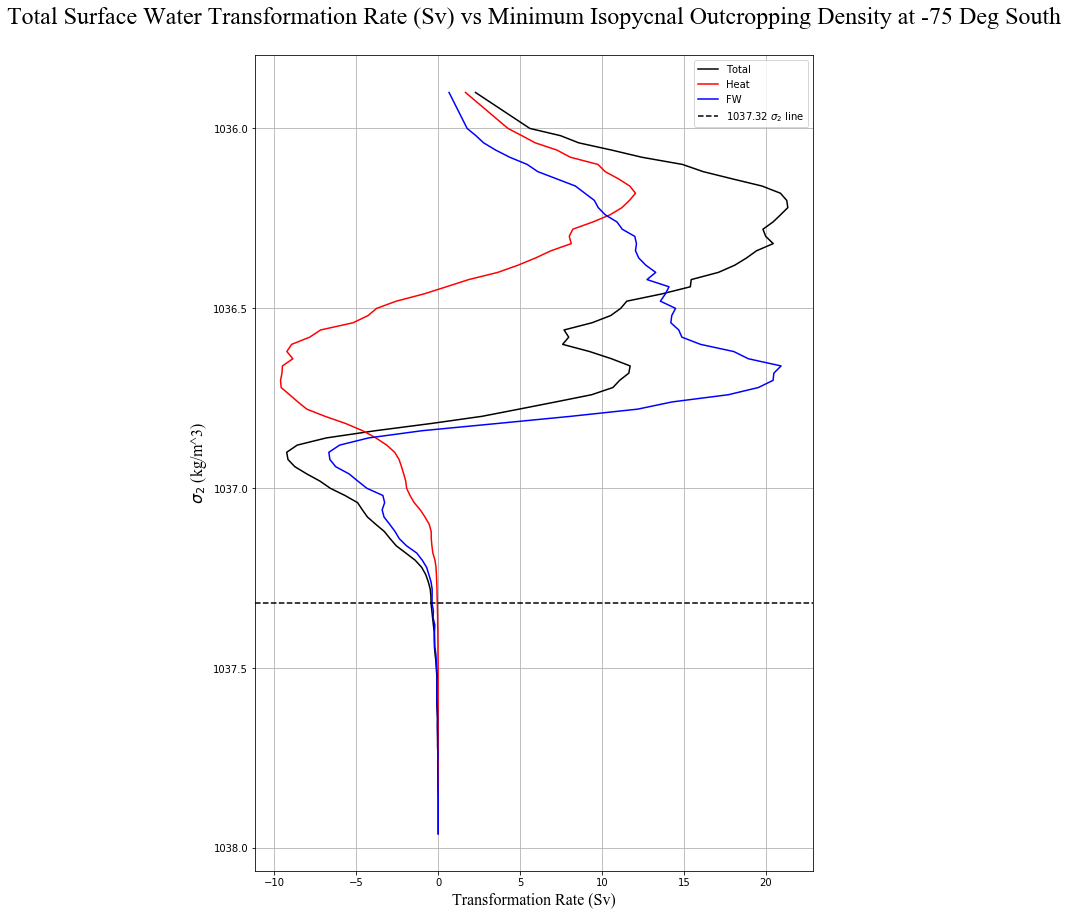

In [158]:
lat_band = -30
pot_rho_min = 50
pot_rho_max = 151

plt.figure(figsize=(10,15))
plt.plot(F_gen_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="k",label="Total")
plt.plot(F_gen_Heat_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="r",label="Heat")
plt.plot(F_gen_FW_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="b",label="FW")
plt.axhline(y=1037.32, color='k', linestyle='--',label="1037.32 $\sigma_{2}$ line")
plt.legend()
plt.gca().invert_yaxis()
plt.grid()
plt.title("Total Surface Water Transformation Rate (Sv) vs Minimum Isopycnal Outcropping Density at "+str(lat_band)+" Deg South\n",fontname='Times New Roman',fontsize=24)
plt.xlabel("Transformation Rate (Sv)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.show()

lat_band = -75
pot_rho_min = 50
pot_rho_max = 151

plt.figure(figsize=(10,15))
plt.plot(F_gen_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="k",label="Total")
plt.plot(F_gen_Heat_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="r",label="Heat")
plt.plot(F_gen_FW_array_t_mean.isel(lat=lat_band)[pot_rho_min:pot_rho_max]/(1e6),F_gen_array_t_mean.pot_rho[pot_rho_min:pot_rho_max],c="b",label="FW")
plt.axhline(y=1037.32, color='k', linestyle='--',label="1037.32 $\sigma_{2}$ line")
plt.legend()
plt.gca().invert_yaxis()
plt.grid()
plt.title("Total Surface Water Transformation Rate (Sv) vs Minimum Isopycnal Outcropping Density at "+str(lat_band)+" Deg South\n",fontname='Times New Roman',fontsize=24)
plt.xlabel("Transformation Rate (Sv)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.show()